# Flop or Not? (Binary Classification)

# Setup

In [1]:
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

from cleaning_tools import flatten, flatten_people, one_hot

# read in data
%store -r raw_data

# Cleaning
Zero make sense for `vote_average` and `vote_count`. Hence, we only need to check null values

In [2]:
raw_data[["vote_average", "vote_count"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   vote_average  5000 non-null   float64
 1   vote_count    5000 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 78.2 KB


# Implement V-Score
Suppose a film has a `vote_average` = $a$ and `vote_count` = $n$. Then its $V$-score is given by:
$$
V \vcentcolon= \frac{\frac{a}{10}n + 1}{n + 2}
$$

We add a new column of $V$-scores to the dataframe. 

In [3]:
raw_data["v_score"] = ((raw_data["vote_average"]/10) * raw_data["vote_count"] + 1) / (raw_data["vote_count"] + 2)

Observe the distribution of $V$-scores. 

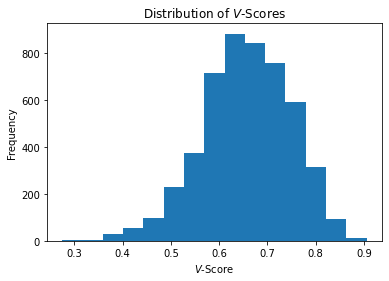

In [4]:
plt.figure(facecolor="white")

raw_data["v_score"].plot.hist(bins=15)

plt.title("Distribution of $V$-Scores")
plt.xlabel("$V$-Score")

plt.draw()
plt.show()

The distribution is slightly left skewed, which makes sense since the top $5000$ most popular movies are presumably well received. Keeping this in mind, let's use $65\%$ as the threshold for a flop (credit at Sydney Uni!).

In [5]:
raw_data["flop"] = raw_data["v_score"] < 0.65
raw_data[["flop"]].value_counts(sort=False)

flop 
False    2621
True     2379
dtype: int64

Visualise the split of flops to non-flops as well. 

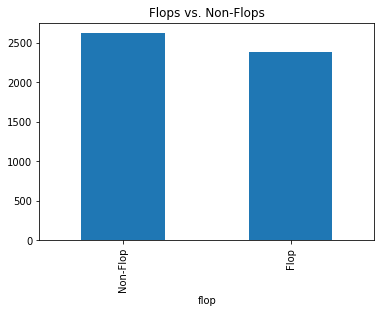

In [6]:
plt.figure(facecolor="white")

raw_data[["flop"]].value_counts(sort=False).plot.bar()

plt.title("Flops vs. Non-Flops")
plt.xticks(ticks=[0, 1], labels=["Non-Flop", "Flop"])

plt.draw()
plt.show()

# Data Preprocessing

## Released Films Only
We are only interested in released films. 

In [7]:
released_only = raw_data[raw_data["released"] == True]

## Zero Values

As we did in `exploratory.ipynb`, we should remove films with zero `budget`, `revenue`, or `runtime`. Notice that one major flaw to our data is that we are missing a lot of `budget` and `revenue` values. 

In [8]:
clean_budget = released_only[released_only["budget"] != 0]
clean_budget_and_revenue = clean_budget[clean_budget["revenue"] != 0]
data_zeroes_cleaned = clean_budget_and_revenue[clean_budget_and_revenue["runtime"] != 0]

data_zeroes_cleaned.shape


(2648, 26)

We lost over half of our observations, but there aren't really other alternatives. 

## Feature Scaling

It is good practice to ensure that all features are on the scale. In our dataset, `budget` and `revenue` will obviously be on a different scale to `runtime`. These are the only numerical features. 

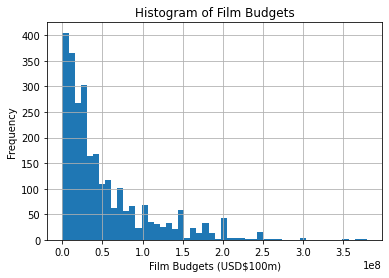

In [9]:
plt.figure(facecolor="white")

data_zeroes_cleaned["budget"].hist(bins=50)

plt.title("Histogram of Film Budgets")
plt.ylabel("Frequency")
plt.xlabel("Film Budgets (USD$100m)")

plt.draw()
plt.show()

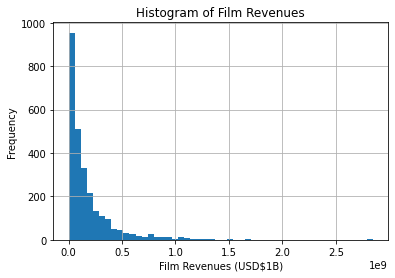

In [10]:
plt.figure(facecolor="white")

data_zeroes_cleaned["revenue"].hist(bins=50)

plt.title("Histogram of Film Revenues")
plt.ylabel("Frequency")
plt.xlabel("Film Revenues (USD$1B)")

plt.draw()
plt.show()

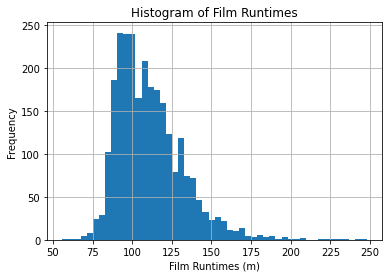

In [11]:
plt.figure(facecolor="white")

data_zeroes_cleaned["runtime"].hist(bins=50)

plt.title("Histogram of Film Runtimes")
plt.ylabel("Frequency")
plt.xlabel("Film Runtimes (m)")

plt.draw()
plt.show()


In [12]:
scaled_data = data_zeroes_cleaned

minmax_scaler = preprocessing.MinMaxScaler()

scaled_data[["budget", "revenue", "runtime"]] = minmax_scaler.fit_transform(data_zeroes_cleaned[["budget", "revenue", "runtime"]])

/var/folders/sg/rlk9vzs561n15bmvp6y81mxc0000gn/T/ipykernel_66156/1335140770.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_data[["budget", "revenue", "runtime"]] = minmax_scaler.fit_transform(data_zeroes_cleaned[["budget", "revenue", "runtime"]])


In [13]:
scaled_data[["budget", "revenue", "runtime"]].describe()

,budget,revenue,runtime
count,2648.000000,2648.000000,2648.000000
mean,0.134054,0.062589,0.286576
std,0.141252,0.086021,0.110751
min,0.000000,0.000000,0.000000
25%,0.034737,0.011792,0.208333
50%,0.078947,0.033342,0.265625
75%,0.184210,0.076820,0.343750
max,1.000000,1.000000,1.000000


## Dropping Obvious Features

Recall that there are $23$ columns (features) in total in the dataset. Some of these may be irrelevant, others may be too complicated for this task, and some should not be used. Hence, the first step we perform in feature selection is dropping the columns we obviously will not be using. These include:

- `imdb_id`: not relevant
- `popularity`: not useful, popularity can only be calculated after the fact
- `vote_count`, `vote_average`, `v_score`: used in definition of whether a film is a flop
- `release_date`, `released`: not useful, we are already working with released films only
- `overview`, `tagline`, `original_title`, `title`: too complicated, involves NLP, and can be proxied using `keywords`

We drop the above columns.

In [14]:
data_obv_dropped = scaled_data.drop(columns=["imdb_id", "popularity", "vote_count", "vote_average", "overview", "tagline", "original_title", "title", "v_score", "release_date", "released", "status"])
data_obv_dropped.head()

,adult,budget,genres,id,original_language,production_companies,production_countries,revenue,runtime,spoken_languages,keywords,cast,crew,flop
0,False,0.526316,"[Action, Adventure, Science Fiction]",634649,en,"[Marvel Studios, Pascal Pictures, Columbia Pic...",[US],0.659123,0.479167,"[en, tl]","[new york city, hero, villain, comic book, seq...","[{'adult': False, 'gender': 2, 'id': 1136406, ...","[{'adult': False, 'gender': 1, 'id': 2519, 'kn...",False
1,False,0.486842,"[Crime, Mystery, Thriller]",414906,en,"[6th & Idaho, Dylan Clark Productions, DC Film...",[US],0.162690,0.625000,[en],"[dc comics, crime fighter, secret identity, vi...","[{'adult': False, 'gender': 2, 'id': 11288, 'k...","[{'adult': False, 'gender': 2, 'id': 2122, 'kn...",False
3,False,0.131579,"[Animation, Comedy, Family, Fantasy]",568124,en,"[Walt Disney Animation Studios, Walt Disney Pi...",[US],0.084291,0.239583,"[en, es]","[magic, musical, forest, family relationships,...","[{'adult': False, 'gender': 1, 'id': 968367, '...","[{'adult': False, 'gender': 0, 'id': 8159, 'kn...",False
6,False,0.263158,"[Action, Adventure, Thriller, War]",476669,en,"[Marv Films, Cloudy Productions, 20th Century ...","[GB, US]",0.043552,0.390625,[en],"[london, england, spy, world war i, based on c...","[{'adult': False, 'gender': 2, 'id': 5469, 'kn...","[{'adult': False, 'gender': 2, 'id': 497, 'kno...",False
8,False,0.063158,"[Horror, Mystery, Thriller]",646385,en,"[Paramount, Spyglass Entertainment, Project X ...",[US],0.048374,0.302083,[en],"[attempted murder, mask, hallucination, murder...","[{'adult': False, 'gender': 1, 'id': 9206, 'kn...","[{'adult': False, 'gender': 1, 'id': 409, 'kno...",False


### Too Many Missing Values


In [15]:
data_obv_dropped.isna().sum()

adult                   0
budget                  0
genres                  0
id                      0
original_language       0
production_companies    0
production_countries    0
revenue                 0
runtime                 0
spoken_languages        0
keywords                0
cast                    0
crew                    0
flop                    0
dtype: int64

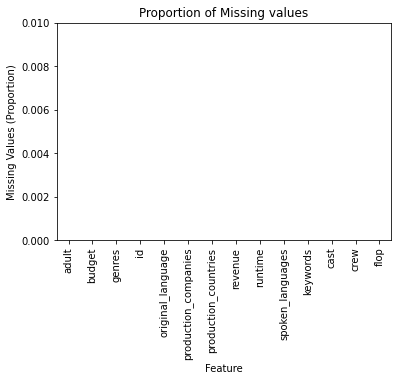

In [16]:
plt.figure(facecolor="white")

(data_obv_dropped.isna().sum() / data_obv_dropped.count()).plot.bar()

plt.title("Proportion of Missing values")
plt.ylabel("Missing Values (Proportion)")
plt.xlabel("Feature")

plt.ylim(0, 0.01)

plt.draw()
plt.show()

### Too Little Variance
Features that do not vary much are not very useful to prediction either. Clearly, this criterion applies only to the numerical columns. 

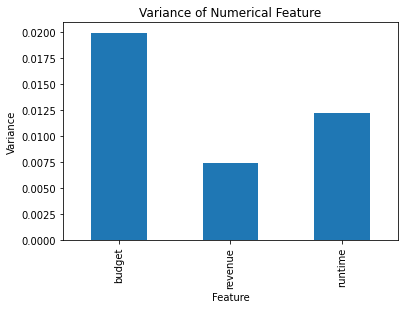

In [17]:
plt.figure(facecolor="white")

data_obv_dropped[["budget", "revenue", "runtime"]].var().plot.bar()

plt.title("Variance of Numerical Feature")
plt.ylabel("Variance")
plt.xlabel("Feature")

plt.draw()
plt.show()

We check for pairwise correlation between the numerical columns

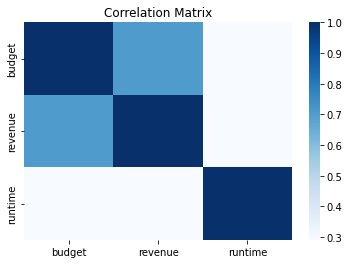

In [18]:
numerical_cols = ["budget", "revenue", "runtime"]

# # visualise
fig = plt.figure(facecolor="white")
sns.heatmap(data_obv_dropped[numerical_cols].corr(), cmap="Blues")

plt.title("Correlation Matrix")

plt.show()


Also check whether or not `adult` has any variance at all. 

In [19]:
data_obv_dropped["adult"].value_counts()

False    2648
Name: adult, dtype: int64

`adult` has no variance, so we drop it. 

In [20]:
data_obv_dropped = data_obv_dropped.drop(columns=["adult"])

## Feature Engineering

There are some features which need to be transformed or reshaped so that we can make predictions.

In [21]:
training_data = data_obv_dropped
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2648 entries, 0 to 4998
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                2648 non-null   float64
 1   genres                2648 non-null   object 
 2   id                    2648 non-null   int64  
 3   original_language     2648 non-null   object 
 4   production_companies  2648 non-null   object 
 5   production_countries  2648 non-null   object 
 6   revenue               2648 non-null   float64
 7   runtime               2648 non-null   float64
 8   spoken_languages      2648 non-null   object 
 9   keywords              2648 non-null   object 
 10  cast                  2648 non-null   object 
 11  crew                  2648 non-null   object 
 12  flop                  2648 non-null   bool   
dtypes: bool(1), float64(3), int64(1), object(8)
memory usage: 271.5+ KB


### Binarisation
We need to convert boolean features (True, False) to binary (0, 1). The code is simple and built into `pandas`. The only boolean feature is `flop`. 

In [22]:
training_data[["flop"]] = training_data[["flop"]].replace({True: 1, False: 0})
training_data[["flop"]].value_counts()

flop
0       1440
1       1208
dtype: int64

### One Hot Encoding
Categorical features will need to be one hot encoded. We already wrote the code to one hot encode categorical features. The categorical features are `genres`, `original_language`, `production_companies`, `production_countries`, `spoken_languages`, and `keywords`. However, the large number of unique labels in each of these categorical features will result in an untractable number of one-hot encoded columns. Hence, we need an alternative. 

A standard approach is the "top $\rho$ most frequent labels". The original authors used top $10$ most frequent, but we use $\rho$ so that this can be a hyperparameter to be tuned in the optimisation stage. 

https://youtu.be/6WDFfaYtN6s


In [23]:
ohe_cols = ["genres", "original_language", "production_companies", "production_countries", "spoken_languages", "keywords"]

for col in ohe_cols:
    flat_training_data = flatten(training_data, [col])
    print("{}: {} labels".format(col, len(flat_training_data[col].unique())))


genres: 19 labels
original_language: 23 labels
production_companies: 3233 labels
production_countries: 59 labels
spoken_languages: 78 labels
keywords: 7770 labels


In [24]:
# hyperparameter
rho = 10

In [25]:
flatten(training_data, ["genres"])["genres"].value_counts()

Action             956
Drama              843
Comedy             826
Thriller           804
Adventure          737
Fantasy            442
Science Fiction    440
Family             437
Horror             411
Crime              364
Romance            320
Animation          299
Mystery            239
History            115
War                 93
Music               49
Western             34
Documentary          4
TV Movie             1
Name: genres, dtype: int64

In [26]:
top_rho = [x for x in flatten(training_data, ["genres"])["genres"].value_counts(ascending=False).head(rho).index]
top_rho

['Action',
 'Drama',
 'Comedy',
 'Thriller',
 'Adventure',
 'Fantasy',
 'Science Fiction',
 'Family',
 'Horror',
 'Crime']

In [27]:
flat_data = flatten(training_data, ohe_cols)
top_rho_all_cols = []
for col in ohe_cols:
    top_rho_all_cols.append([
        x for x in flat_data[col].value_counts().head(rho).index
    ])

In [28]:
training_data_copy = training_data.copy()
i = 0
while i < len(ohe_cols):
    col = ohe_cols[i]
    training_data_copy[col] = [1 if not(set(x).isdisjoint(set(top_rho_all_cols[i]))) else 0 for x in training_data[col]]

    i += 1

training_data_copy.head()

,budget,genres,id,original_language,production_companies,production_countries,revenue,runtime,spoken_languages,keywords,cast,crew,flop
0,0.526316,1,634649,0,1,1,0.659123,0.479167,1,1,"[{'adult': False, 'gender': 2, 'id': 1136406, ...","[{'adult': False, 'gender': 1, 'id': 2519, 'kn...",0
1,0.486842,1,414906,0,1,1,0.162690,0.625000,1,1,"[{'adult': False, 'gender': 2, 'id': 11288, 'k...","[{'adult': False, 'gender': 2, 'id': 2122, 'kn...",0
3,0.131579,1,568124,0,1,1,0.084291,0.239583,1,0,"[{'adult': False, 'gender': 1, 'id': 968367, '...","[{'adult': False, 'gender': 0, 'id': 8159, 'kn...",0
6,0.263158,1,476669,0,0,1,0.043552,0.390625,1,1,"[{'adult': False, 'gender': 2, 'id': 5469, 'kn...","[{'adult': False, 'gender': 2, 'id': 497, 'kno...",0
8,0.063158,1,646385,0,1,1,0.048374,0.302083,1,1,"[{'adult': False, 'gender': 1, 'id': 9206, 'kn...","[{'adult': False, 'gender': 1, 'id': 409, 'kno...",0


For this task, we simply extract the `names` cast and crew members of each film and again apply one hot encoding based on whether or not the top $\rho$ cast (or crew) are present. This is done both for simplicity. In the future, a more complex approach may be performed as an addendum. 

In [29]:
for i in training_data_copy.index:
    cast_names = [x["name"] for x in training_data["cast"][i]]
    crew_names = [x["name"] for x in training_data["crew"][i]]

    training_data_copy.at[i, "cast"] = cast_names
    training_data_copy.at[i, "crew"] = crew_names

In [30]:
training_data_copy.head()

,budget,genres,id,original_language,production_companies,production_countries,revenue,runtime,spoken_languages,keywords,cast,crew,flop
0,0.526316,1,634649,0,1,1,0.659123,0.479167,1,1,"[Tom Holland, Zendaya, Benedict Cumberbatch, J...","[Sanja Milković Hays, Sarah Halley Finn, Stan ...",0
1,0.486842,1,414906,0,1,1,0.162690,0.625000,1,1,"[Robert Pattinson, Zoë Kravitz, Paul Dano, Jef...","[William Hoy, Frank Miller, Bob Kane, Michael ...",0
3,0.131579,1,568124,0,1,1,0.084291,0.239583,1,0,"[Stephanie Beatriz, María Cecilia Botero, John...","[Shannon Mills, Clark Spencer, Byron Howard, D...",0
6,0.263158,1,476669,0,0,1,0.043552,0.390625,1,1,"[Ralph Fiennes, Harris Dickinson, Gemma Artert...","[Doug J. Meerdink, Matthew Vaughn, Matthew Vau...",0
8,0.063158,1,646385,0,1,1,0.048374,0.302083,1,1,"[Neve Campbell, Courteney Cox, David Arquette,...","[Cathy Konrad, Roger Birnbaum, Gary Barber, We...",0


Like above, we can now binarise `cast` and `crew` columns, assigning a 1 if a film has any of the top $\rho$ most common cast or crew members present, and a 0 otherwise. 

In [31]:
flat_people = flatten(training_data_copy, ["cast", "crew"])
top_rho_ppl_cols = []
for col in ["cast", "crew"]:
    top_rho_ppl_cols.append([
        x for x in flat_people[col].value_counts().head(rho).index
    ])

In [32]:
i = 0
while i < len(["cast", "crew"]):
    col = ["cast", "crew"][i]
    training_data_copy[col] = [1 if not(set(x).isdisjoint(set(top_rho_ppl_cols[i]))) else 0 for x in training_data_copy[col]]

    i += 1

# Model Building

Following the above procedure, we have now arrived at a dataset on which we can run the standard binary classification algorithms. 

In [33]:
training_data_copy.head()

,budget,genres,id,original_language,production_companies,production_countries,revenue,runtime,spoken_languages,keywords,cast,crew,flop
0,0.526316,1,634649,0,1,1,0.659123,0.479167,1,1,0,1,0
1,0.486842,1,414906,0,1,1,0.162690,0.625000,1,1,0,0,0
3,0.131579,1,568124,0,1,1,0.084291,0.239583,1,0,0,0,0
6,0.263158,1,476669,0,0,1,0.043552,0.390625,1,1,0,0,0
8,0.063158,1,646385,0,1,1,0.048374,0.302083,1,1,0,0,0


Assign the independent and dependent variables. 

In [34]:
X = training_data_copy[["budget", "genres", "original_language", "original_language", "production_companies", "production_countries", "revenue", "runtime", "spoken_languages", "keywords", "cast", "crew"]]
y = training_data_copy["flop"]

Split data into training and test sets, with `test_size` equal to $\gamma$ which will also be a hyperparameter to be tuned. 

In [35]:
gamma = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=gamma, random_state=0)
initial_training_data = (X_train, X_test, y_train, y_test)
test_pts = X_test.shape[0]

## Null Model
The null model predicts everything as the majority, which gives us a baseline accuracy. If any model is underperforming this null model, something must be wrong! 

In [36]:
# get the majority (in this case it should be 0 (not a flop))
majority = training_data_copy["flop"].value_counts().idxmax()
# predict all test points as 0 (not a flop)
null_predict = np.array([majority] * len(y_test))
# get the number of correctly predicted points
null_correct_pts = (null_predict == y_test).sum()

print("Number of correctly labeled points out of total {} points: {}".format(test_pts, null_correct_pts))
print("Percentage of correctly labeled points: {}%".format(round(null_correct_pts / test_pts, 2) * 100))

Number of correctly labeled points out of total 1324 points: 718
Percentage of correctly labeled points: 54.0%


## Helper Function
We create a helper function to quickly fit a classifier given a training-test split. 

In [37]:
def train_model(classifier, data, show=True):
    '''
    INPUTS:     classifier:     (sklearn classifier) the classifier to be used, e.g. GaussianNB()
                X_train:        (pd.DataFrame) training set of independent variables 
                y_train:        (pd.Series) training set of dependent variable
                X_test:         (pd.DataFrame) test set of independent variables
                y_test:         (pd.Series) test set of dependent variables
                show:           (bool) whether or not to print accuracy results
    
    OUTPUT:     model:          (sklearn fitted object)
                pred:           (np.ndarray) array of predicted data points given X-test, using classifier, and trained on X_train and y_train
                correct_pts:    (int) number of correctly fitted points
    '''
    
    (X_train, X_test, y_train, y_test) = data

    fitted = classifier.fit(X_train, y_train)
    pred = fitted.predict(X_test)
    correct_pts = (y_test == pred).sum()

    if show:
        print("Number of correctly labeled points out of total {} points: {}".format(test_pts, correct_pts))
        print("Percentage of correctly labeled points: {}%".format(round(correct_pts / test_pts, 2) * 100))    
    
    return (fitted, pred, correct_pts)


## Naive Bayes
Description of each and formula. 

In [38]:
# gaussian naive bayes
(gnb_fitted, gnb_predict, gnb_correct_pts) = train_model(GaussianNB(), initial_training_data, show=False)
# multinomial naive bayes
(mnb_fitted, mnb_predict, mnb_correct_pts) = train_model(MultinomialNB(), initial_training_data, show=False)
# complement naive bayes
(cmp_fitted, cmp_predict, cmp_correct_pts) = train_model(ComplementNB(), initial_training_data, show=False)
# bernoulli naive bayes
(ber_fitted, ber_predict, ber_correct_pts) = train_model(BernoulliNB(), initial_training_data, show=False)
# categorical naive bayes
(cat_fitted, cat_predict, cat_correct_pts) = train_model(CategoricalNB(), initial_training_data, show=False)

## Logistic Regression
One line description and formula.

In [39]:
# logistic regression
(log_fitted, log_predict, log_correct_pts) = train_model(LogisticRegression(), initial_training_data, show=False)

## k-Nearest Neighbours
One line description and formula.

$k$ will be a hyperparameter. 

In [40]:
# k-nearest neighbours
(knn_fitted, knn_predict, knn_correct_pts) = train_model(KNeighborsClassifier(), initial_training_data, show=False)

## Decision Trees & Random Forests
One line description and formula.

Max-depth will be a hyperparameter. 

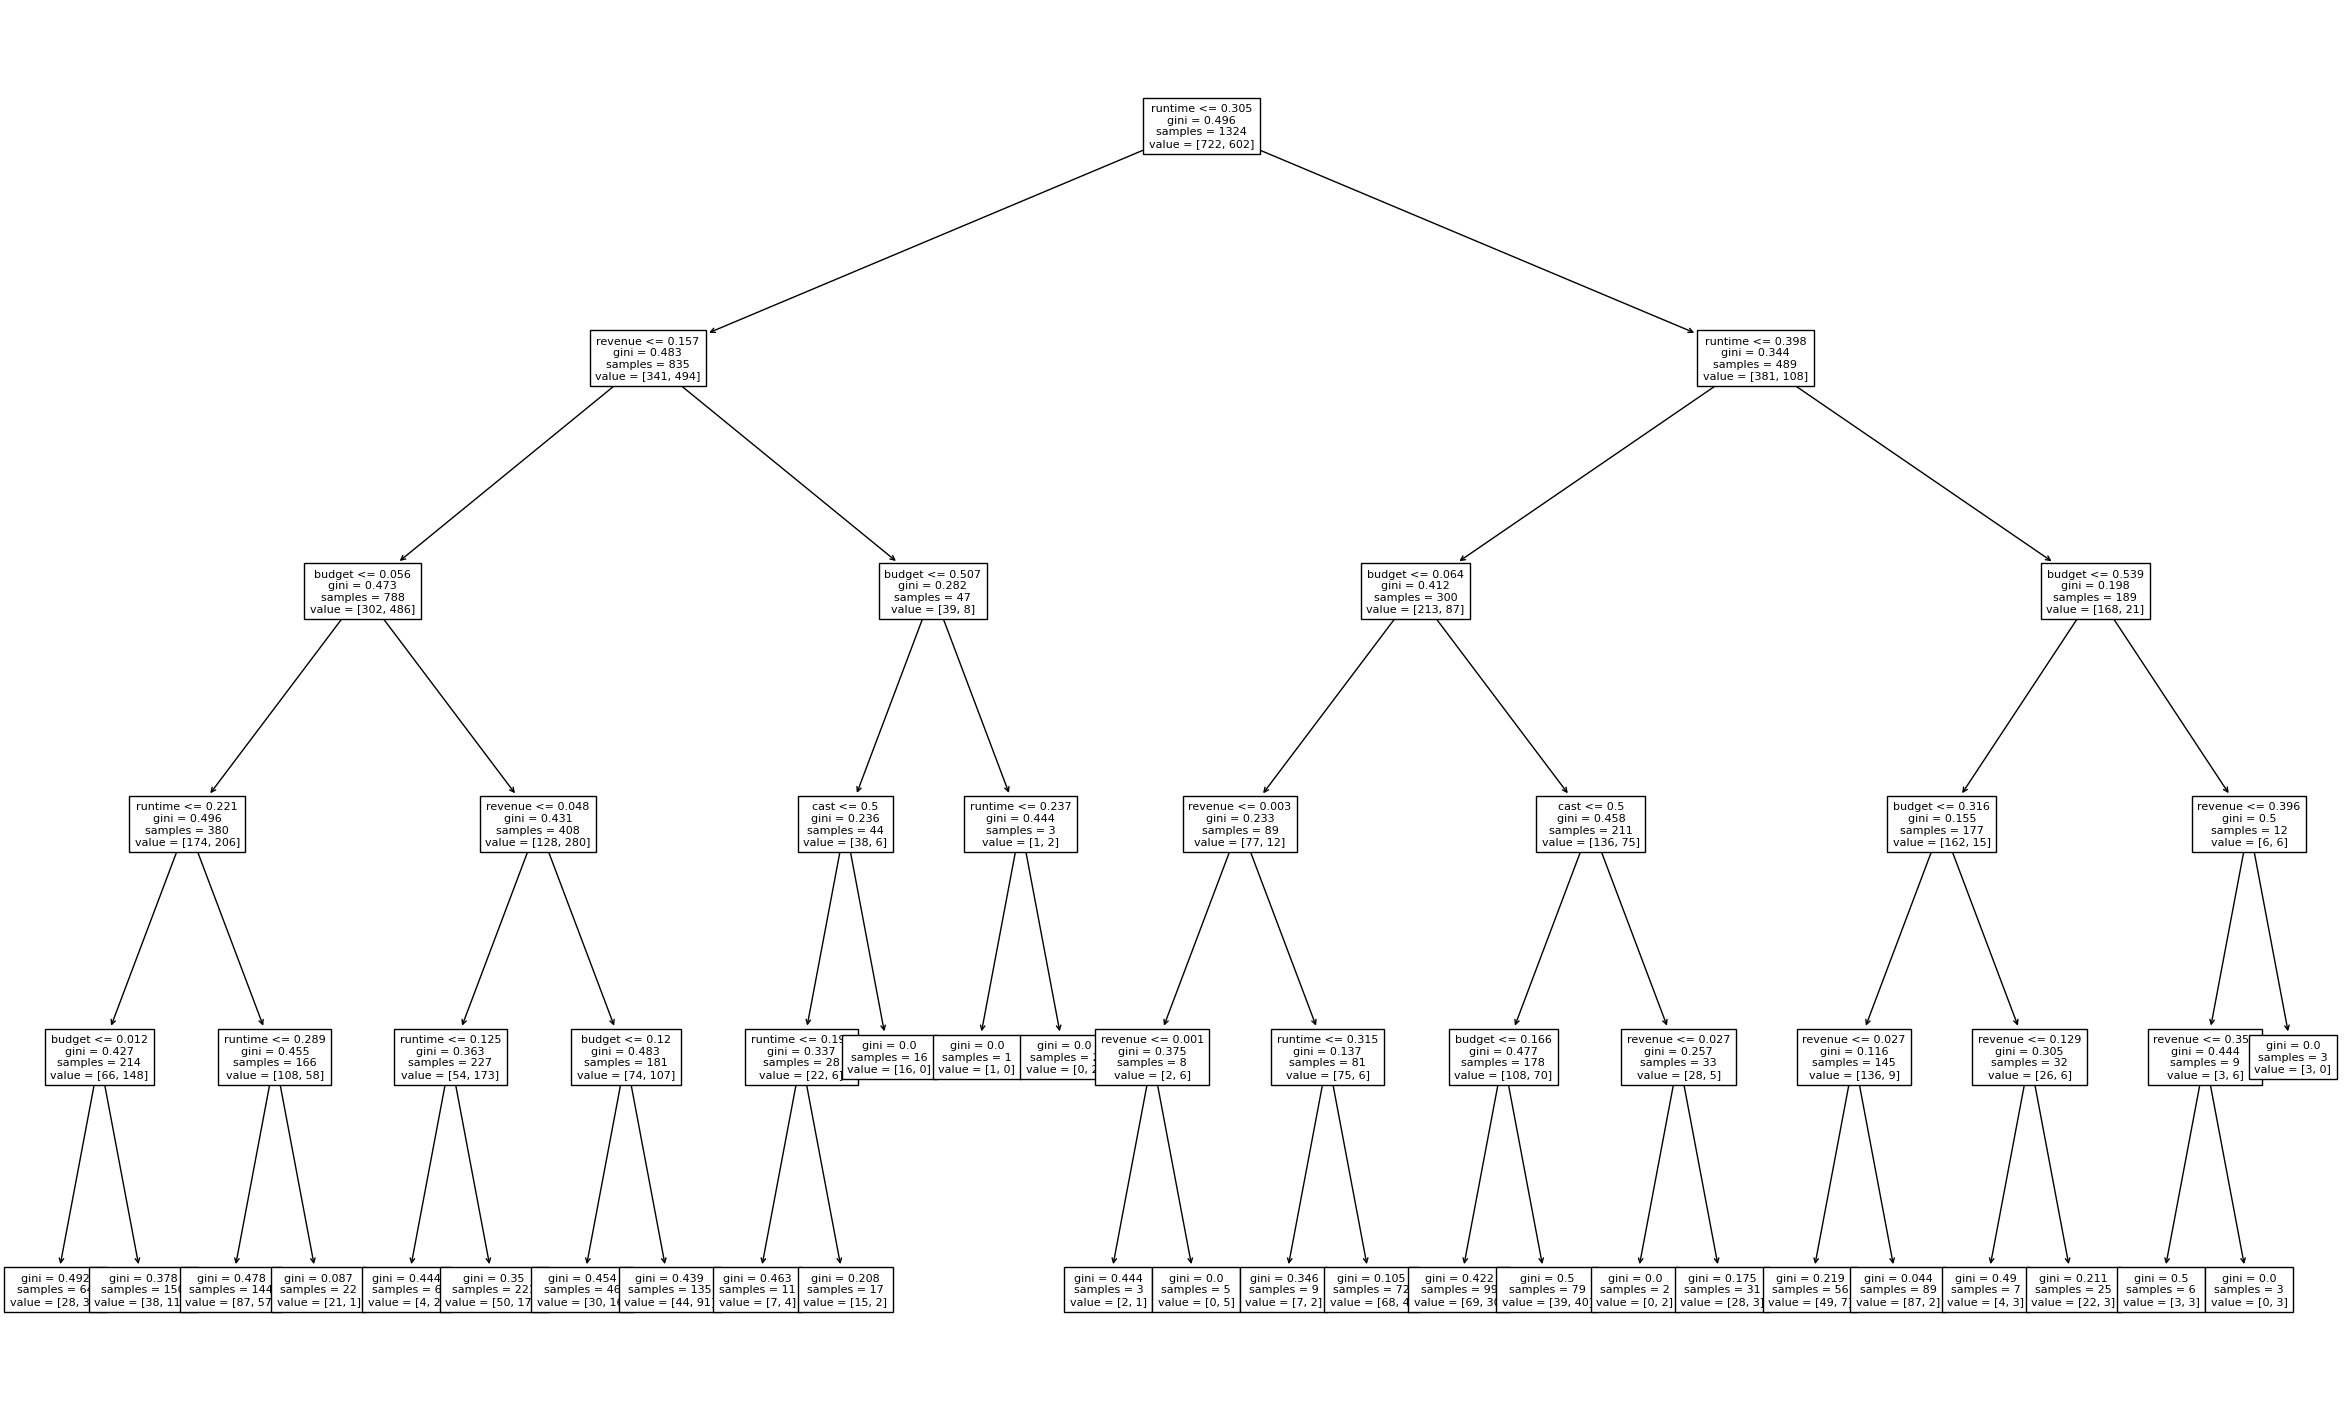

In [41]:
# decision trees
# DecisionTreeClassifier takes max_depth=int 
(tree_fitted, tree_predict, tree_correct_pts) = train_model(tree.DecisionTreeClassifier(max_depth=5), initial_training_data, show=False)
plt.figure(facecolor="white", figsize=(30, 18.5), dpi=100)
tree.plot_tree(tree_fitted, feature_names=X_train.columns, fontsize=8)
plt.savefig("tree.png")

In [42]:
# random forests
(forest_fitted, forest_predict, forest_correct_pts) = train_model(RandomForestClassifier(), initial_training_data, show=False)

## Support Vector Machines
One line description and formula.

In [43]:
# SVM
(svm_fitted, svm_predict, svm_correct_pts) = train_model(SVC(), initial_training_data, show=False)

# Model Evaluation

## In-Sample Performance

In [44]:
models = [GaussianNB(), MultinomialNB(), ComplementNB(), BernoulliNB(), CategoricalNB(), LogisticRegression(), KNeighborsClassifier(), tree.DecisionTreeClassifier(), RandomForestClassifier(), SVC()]
model_names = ["GaussianNB", "MultinomialNB", "ComplementNB", "BernoulliNB", "CategoricalNB", "Logistic Regression", "kNN", "Decision Trees", "Random Forests", "SVM"]
metrics = ["Accuracy", "Precision", "Recall", "F1"]
predicts = [gnb_predict, mnb_predict, cmp_predict, ber_predict, cat_predict, log_predict, knn_predict, tree_predict, forest_predict, svm_predict]

metrics = []
i = 0
while i < len(model_names):
    model_name = model_names[i]
    model_predicts = predicts[i]

    model_metrics = dict()
    model_metrics["Accuracy"] = accuracy_score(y_test, model_predicts)
    model_metrics["Precision"] = precision_score(y_test, model_predicts)
    model_metrics["Recall"] = recall_score(y_test, model_predicts)
    model_metrics["F1"] = f1_score(y_test, model_predicts)
    
    metrics.append(model_metrics)

    i += 1

metrics = pd.DataFrame(metrics)
metrics.index = model_names
metrics

,Accuracy,Precision,Recall,F1
GaussianNB,0.579305,0.522833,0.925743,0.668255
MultinomialNB,0.556647,0.576000,0.118812,0.196990
ComplementNB,0.558912,0.514589,0.640264,0.570588
BernoulliNB,0.556647,0.516351,0.495050,0.505476
CategoricalNB,0.556647,0.516351,0.495050,0.505476
Logistic Regression,0.679758,0.650662,0.648515,0.649587
kNN,0.667674,0.628086,0.671617,0.649123
Decision Trees,0.666918,0.621861,0.694719,0.656274
Random Forests,0.667674,0.640678,0.623762,0.632107
SVM,0.656344,0.613876,0.671617,0.641450


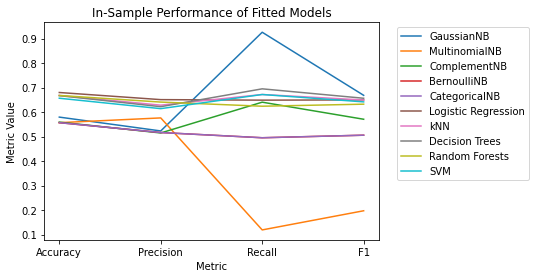

In [45]:
plt.figure(facecolor="white")

for model in model_names:
    plt.plot(metrics.loc[model, :], label=model)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlabel("Metric")
plt.ylabel("Metric Value")
plt.title("In-Sample Performance of Fitted Models")

plt.show()

## Out-Sample Performance (Cross-Validation)

In [46]:
out_sample_perf = dict()
for metric in metrics:    
    cv_scores = dict()
    i = 0
    while i < len(models):
        model = models[i]
        model_name = model_names[i]
        
        # use default 5-fold
        cv_scores[model_name] = cross_val_score(model, X, y, scoring=metric.lower())

        i += 1

    cv_scores = pd.DataFrame(cv_scores).mean()
    out_sample_perf[metric] = cv_scores

out_sample_perf = pd.DataFrame(out_sample_perf)
    

/Users/leoli/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/leoli/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/leoli/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/leoli/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/leoli/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/

KeyboardInterrupt: 

Text(0.5, 1.0, 'Out-Sample Performance of Fitted Models (5-Fold CV)')

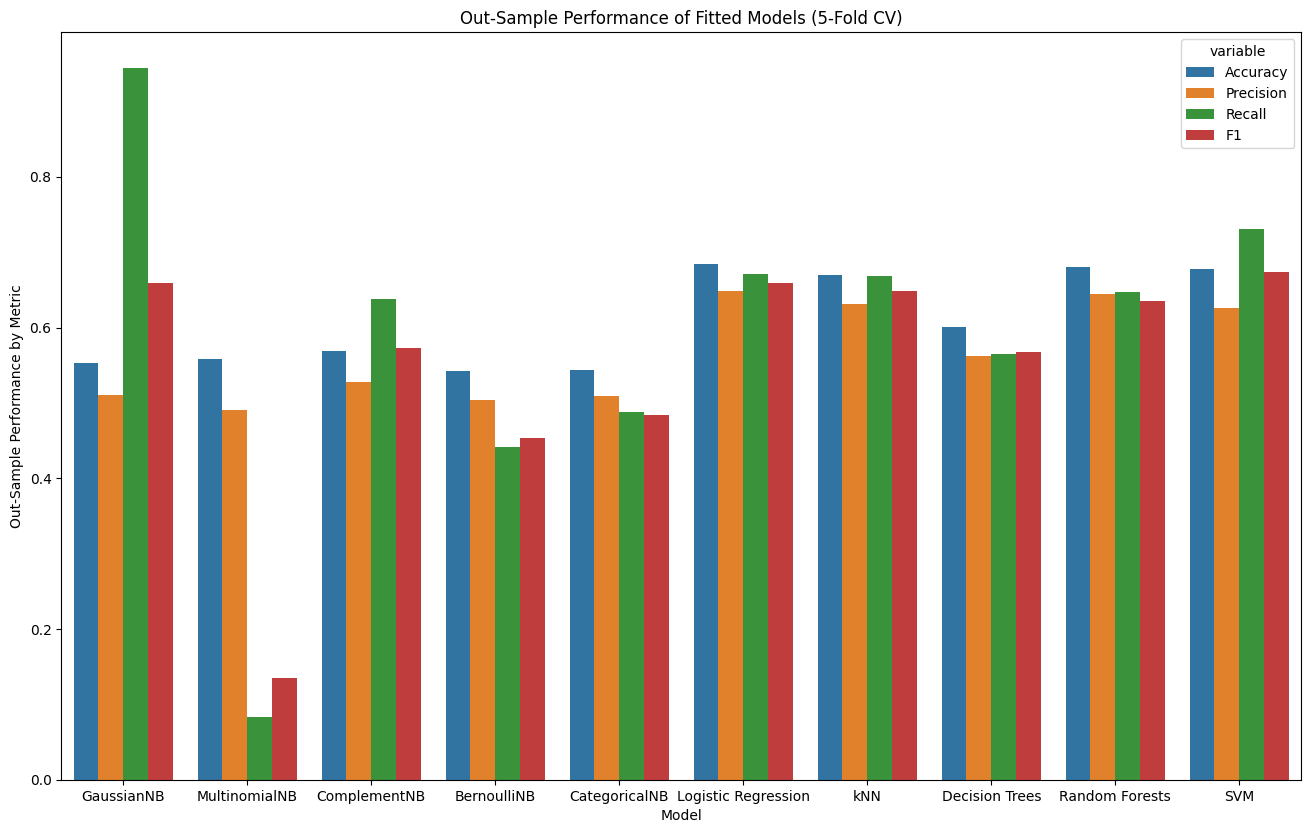

In [ ]:
plt.figure(facecolor="white", figsize=(16, 9.9), dpi=100)

ax = sns.barplot(data=out_sample_perf.reset_index().melt("index"), x="index", y="value", hue="variable")

plt.xlabel("Model")
plt.ylabel("Out-Sample Performance by Metric")
plt.title("Out-Sample Performance of Fitted Models (5-Fold CV)")

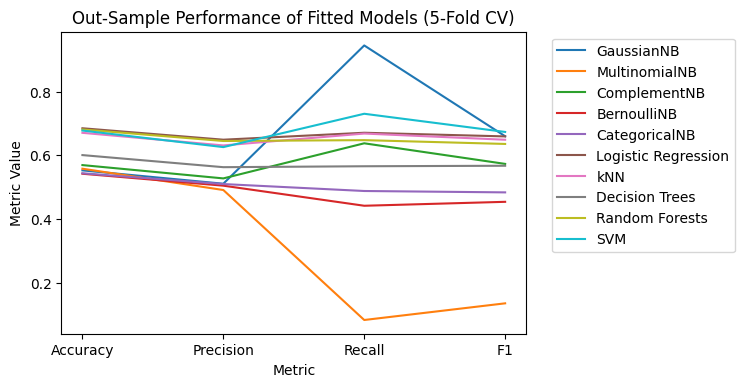

In [ ]:
plt.figure(facecolor="white", dpi=100)

for model in model_names:
    plt.plot(out_sample_perf.loc[model, :], label=model)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlabel("Metric")
plt.ylabel("Metric Value")
plt.title("Out-Sample Performance of Fitted Models (5-Fold CV)")

plt.show()

Test